# Projet Datascientest - Compagnon immo

<code>mar25_bds_compagnon_immo_1</code>

---

## Modélisation évolution des prix - v6.0

---

### Recherche optimisation R2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tabulate import tabulate


from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.preprocessing import RobustScaler, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Bidirectional, GRU, LSTM, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv1D,  Layer
from tensorflow.keras.layers import Activation

### Chargement des données nettoyées

In [2]:
output_path = '../data/processed/dep_21_all_years.csv.gz'
df_dep = pd.read_csv(output_path, low_memory=False, index_col='date_mutation', parse_dates=True)

#### Ajout du taux d'inflation annuel, taux livret A et taux moyen bancaire

In [3]:
# Source INSEE
df_inflation = pd.read_csv('../data/raw/inflation-2020-2024.csv', index_col=0)

df_inflation = df_inflation.drop('mois',axis=1)
df_inflation.rename(columns={'index': 'mois'}, inplace=True)
df_inflation.columns = df_inflation.columns.astype(int)
df_inflation["mois"] = df_inflation.index.astype(int)

def get_inflation(row):
    mois = row['mois']
    annee = row['annee']
    try:
        return df_inflation.loc[mois, annee]
    except KeyError:
        return np.nan

df_dep['taux_inflation'] = df_dep.apply(get_inflation, axis=1)

# Source Banque de France
taux_livret_a = {
     2020: 0.50,
     2021: 0.50,
     2022: 1.38,
     2023: 2.50,
     2024: 3.00,
}
taux_moyen_bancaire = {
     2020: 0.48,
     2021: 0.47,
     2022: 0.78,
     2023: 1.37,
     2024: 1.80,
}
df_dep["taux_livret_a"] = df_dep["annee"].map(taux_livret_a)
df_dep["taux_moyen_bancaire"] = df_dep["annee"].map(taux_moyen_bancaire)

In [6]:
df_dep = df_dep[df_dep['prix_m2_vente'] < 1_000_000]
df_dep = df_dep.drop([
    'id_mutation',
    'nom_commune', 
    'numero_disposition', 
    'lot2_numero', 
    'lot2_surface_carrez',
    'lot3_numero', 
    'lot3_surface_carrez',
    'lot4_numero', 
    'lot4_surface_carrez', 
    'lot5_numero', 
    'lot5_surface_carrez'], axis=1)
df_dep.sample(5)

,nature_mutation,valeur_fonciere,code_commune,code_departement,lot1_numero,lot1_surface_carrez,nombre_lots,code_type_local,type_local,surface_reelle_bati,...,code_nature_culture_speciale,surface_terrain,longitude,latitude,prix_m2_vente,annee,mois,taux_inflation,taux_livret_a,taux_moyen_bancaire
date_mutation,,,,,,,,,,,,,,,,,,,,,
2022-11-14,Vente,150000.0,21231,21,8,63.0,1,2.0,Appartement,63.0,...,NS,0.0,5.036903,47.325221,2380.952381,2022,11,6.2,1.38,0.78
2024-08-22,Vente,77000.0,21231,21,343,48.0,2,2.0,Appartement,48.0,...,NS,0.0,5.035648,47.302945,1604.166667,2024,8,1.8,3.00,1.80
2023-03-08,Vente,413000.0,21540,21,0,0.0,0,5.0,Autre,0.0,...,NS,32.0,5.082526,47.337289,12906.250000,2023,3,5.7,2.50,1.37
2022-01-06,Vente,18000.0,21554,21,0,36.0,0,1.0,Maison,36.0,...,NS,72.0,5.261972,47.101558,500.000000,2022,1,2.9,1.38,0.78
2022-06-01,Vente,65000.0,21554,21,0,55.0,0,1.0,Maison,55.0,...,NS,40.0,5.264380,47.104251,1181.818182,2022,6,5.8,1.38,0.78


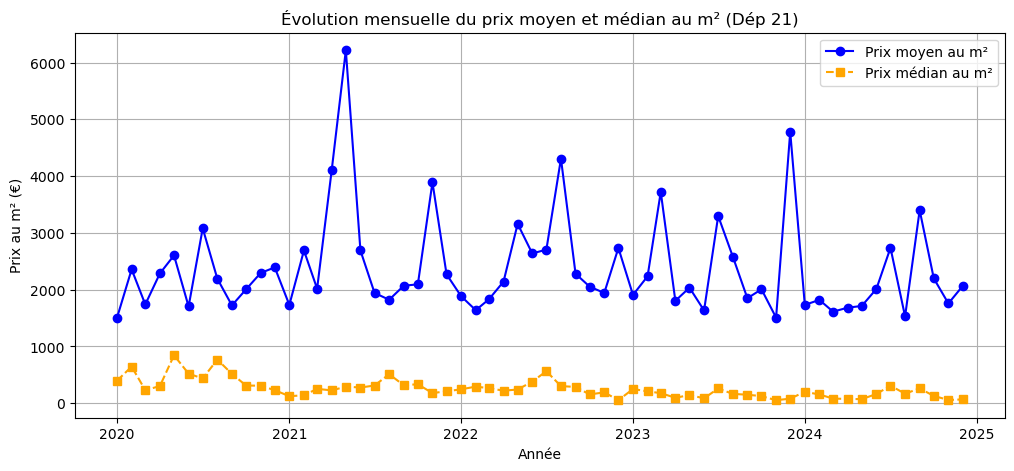

In [9]:
df_monthly = df_dep.groupby(["annee", "mois"]).agg({
    "prix_m2_vente": ["mean", "median"],
    "valeur_fonciere": ["mean", "median"],
    "surface_reelle_bati": "mean",
    "taux_inflation": "first",
    "taux_livret_a": "first",
    "taux_moyen_bancaire": "first"
}).reset_index()

df_monthly.columns = ['_'.join(col) if isinstance(col, tuple) else col for col in df_monthly.columns]
df_monthly = df_monthly.rename(columns={'annee_': 'annee', 
                                        'mois_': 'mois', 
                                        'taux_inflation_first': 'taux_inflation', 
                                        'taux_livret_a_first': 'taux_livret_a', 
                                        'taux_moyen_bancaire_first': 'taux_moyen_bancaire'})
df_monthly["date"] = pd.to_datetime(df_monthly["annee"].astype(str) + "-" + df_monthly["mois"].astype(str) + "-01")

plt.figure(figsize=(12, 5))
plt.plot(df_monthly["date"], df_monthly['prix_m2_vente_mean'], marker="o", linestyle="-", label="Prix moyen au m²", color="blue")
plt.plot(df_monthly["date"], df_monthly['prix_m2_vente_median'], marker="s", linestyle="--", label="Prix médian au m²", color="orange")

plt.xlabel("Année")
plt.ylabel("Prix au m² (€)")
plt.title("Évolution mensuelle du prix moyen et médian au m² (Dép 21)")
plt.legend()
plt.grid(True)

plt.show();

In [11]:
df_monthly.head()

,annee,mois,prix_m2_vente_mean,prix_m2_vente_median,valeur_fonciere_mean,valeur_fonciere_median,surface_reelle_bati_mean,taux_inflation,taux_livret_a,taux_moyen_bancaire,date
0,2020,1,1506.816871,397.140838,129972.852925,100000.0,43.088805,1.5,0.5,0.48,2020-01-01
1,2020,2,2356.887183,643.216080,210187.870806,113000.0,40.795096,1.4,0.5,0.48,2020-02-01
2,2020,3,1738.840707,229.371310,164602.626400,92937.5,39.267778,0.7,0.5,0.48,2020-03-01
3,2020,4,2284.745550,300.976909,148826.019440,105000.0,35.163921,0.3,0.5,0.48,2020-04-01
4,2020,5,2603.167428,843.504902,182486.600262,121000.0,44.196619,0.4,0.5,0.48,2020-05-01


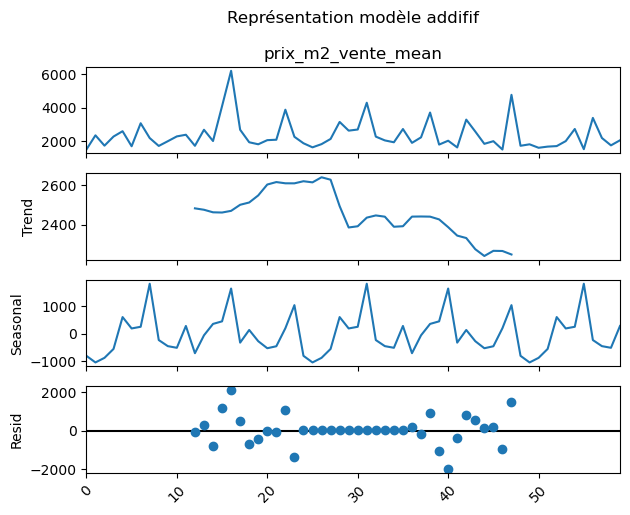

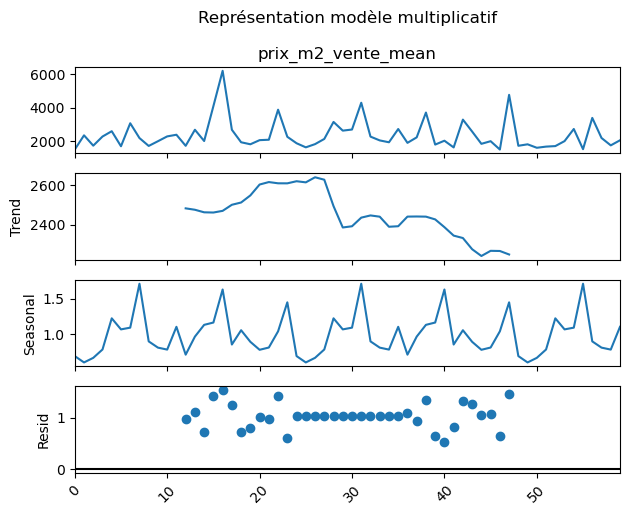

In [37]:
result = seasonal_decompose(df_monthly['prix_m2_vente_mean'], period=24)
result.plot()
plt.xticks(rotation=45)
plt.title('Représentation modèle addifif', y=5.1)
plt.show();

result = seasonal_decompose(df_monthly['prix_m2_vente_mean'], model='multiplicative', period=24)
result.plot()
plt.xticks(rotation=45)
plt.title('Représentation modèle multiplicatif', y=5.1)
plt.show();

In [43]:
decomposition_additive = seasonal_decompose(df_monthly['prix_m2_vente_mean'], period=12)
decomposition_multiplicative = seasonal_decompose(df_monthly['prix_m2_vente_mean'], model='multiplicative', period=12)

# Résidus pour les deux modèles
resid_add = decomposition_additive.resid.dropna()
resid_mult = decomposition_multiplicative.resid.dropna()

# Calcul l'écart-type des résidus
std_add = resid_add.std()
std_mult = resid_mult.std()
serie_type = 'additif' if std_add < std_mult else 'multiplicatif'

data = [
    ["Écart-type des résidus (Additif)", std_add],
    ["Écart-type des résidus (Multiplicatif) :", std_mult],
    ["Type de la série :", serie_type],
]
print(tabulate(data, headers=["Description", "Value"], tablefmt="grid"))

+------------------------------------------+--------------------+
| Description                              | Value              |
+==========================================+====================+
| Écart-type des résidus (Additif)         | 819.6817028787043  |
+------------------------------------------+--------------------+
| Écart-type des résidus (Multiplicatif) : | 0.2928049745067783 |
+------------------------------------------+--------------------+
| Type de la série :                       | multiplicatif      |
+------------------------------------------+--------------------+


                                     SARIMAX Results                                      
Dep. Variable:               prix_m2_vente_median   No. Observations:                   48
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                -305.890
Date:                            Mon, 19 May 2025   AIC                            621.781
Time:                                    18:22:32   BIC                            631.137
Sample:                                         0   HQIC                           625.316
                                             - 48                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9804      0.028     34.910      0.000       0.925       1.035
ma.L1         -0.6508      0.116   

C:\Users\tabod\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\tabod\AppData\Local\Temp\ipykernel_13980\367051933.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["sarima_pred"] = model_sarima.predict(start=len(train), end=len(train) + len(test) - 1)


,Dataset,MAE,RMSE,R²,MAPE (%)
0,Train,109.926282,153.422057,0.190082,47.392081
1,Test,60.208866,81.795772,-0.101328,33.675467


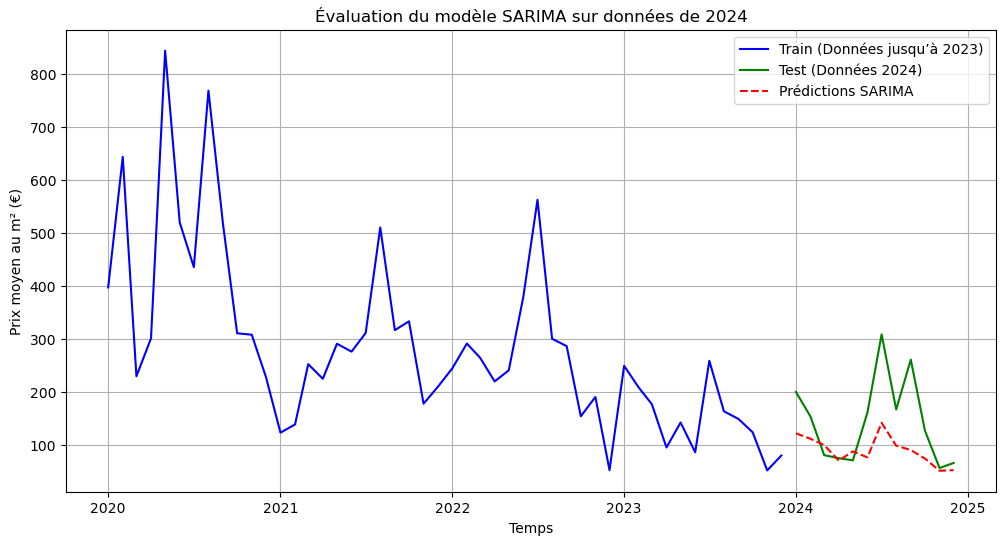

In [55]:
train = df_monthly[df_monthly["annee"] < 2024]
test = df_monthly[df_monthly["annee"] == 2024]  

model_sarima = SARIMAX(train["prix_m2_vente_median"], order=(1, 0, 1), seasonal_order=(1, 0, 1, 12))
model_sarima = model_sarima.fit()

print(model_sarima.summary())

y_true_train = train["prix_m2_vente_median"]
y_pred_train = model_sarima.predict(start=0, end=len(train) - 1)

mae_train = mean_absolute_error(y_true_train, y_pred_train)
rmse_train = np.sqrt(mean_squared_error(y_true_train, y_pred_train))
r2_train = r2_score(y_true_train, y_pred_train)
mape_train = np.mean(np.abs((y_true_train - y_pred_train) / y_true_train)) * 100

test["sarima_pred"] = model_sarima.predict(start=len(train), end=len(train) + len(test) - 1)

y_true_test = test["prix_m2_vente_median"]
y_pred_test = test["sarima_pred"]

mae_test = mean_absolute_error(y_true_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_true_test, y_pred_test))
r2_test = r2_score(y_true_test, y_pred_test)
mape_test = np.mean(np.abs((y_true_test - y_pred_test) / y_true_test)) * 100

df_scores = pd.DataFrame({
    "Dataset": ["Train", "Test"],
    "MAE": [mae_train, mae_test],
    "RMSE": [rmse_train, rmse_test],
    "R²": [r2_train, r2_test],
    "MAPE (%)": [mape_train, mape_test]
})

display(df_scores)

plt.figure(figsize=(12, 6))
plt.plot(train["date"], train["prix_m2_vente_median"], label="Train (Données jusqu’à 2023)", color="blue")
plt.plot(test["date"], test["prix_m2_vente_median"], label="Test (Données 2024)", color="green")
plt.plot(test["date"], test["sarima_pred"], label="Prédictions SARIMA", color="red", linestyle="--")

plt.xlabel("Temps")
plt.ylabel("Prix moyen au m² (€)")
plt.title("Évaluation du modèle SARIMA sur données de 2024")
plt.legend()
plt.grid(True)
plt.show();

In [ ]:
df_prophet = df_monthly.reset_index()[['date','prix_m2_vente_median']].rename(
    columns={'date': 'ds', 'prix_m2_vente_median': 'y'}
)

df_prophet = df_monthly[['date', 
                         'prix_m2_vente_median', 
                         'taux_inflation', 
                         'taux_livret_a', 
                         'taux_moyen_bancaire', 
                         'valeur_fonciere_mean', 
                         'surface_reelle_bati_mean']].rename(columns={'date': 'ds', 'prix_m2_vente_median': 'y'}).dropna()


df_train = df_prophet[df_prophet["ds"].dt.year < 2024]
df_test = df_prophet[df_prophet["ds"].dt.year == 2024]

df_train = df_train.reset_index(drop=True)
df_train['ds'] = pd.to_datetime(df_train['ds'])

model_prophet = Prophet()
model_prophet.fit(df_train[['ds', 'y', 'taux_inflation', 'valeur_fonciere_mean']])


future_dates = model_prophet.make_future_dataframe(periods=12, freq="MS")
forecast = model_prophet.predict(future_dates)

forecast_2024 = forecast[forecast["ds"].dt.year == 2024]

plt.figure(figsize=(15, 5))
plt.plot(df_test["ds"], df_test["y"], label="Valeurs réelles (2024)", marker="o")
plt.xlim(pd.to_datetime(["2024-01-01", "2024-12-31"]))
plt.plot(forecast_2024["ds"], forecast_2024["yhat"], label="Prédictions Prophet (2024)", linestyle="dashed", marker="x")

# Intervalle de confiance
plt.fill_between(forecast_2024["ds"], forecast_2024["yhat_lower"], forecast_2024["yhat_upper"], color="gray", alpha=0.2)
plt.legend()
plt.title("Comparaison des prix réels vs prédits avec Prophet (2024)")
plt.xticks(rotation=45)
plt.show();

mae = mean_absolute_error(df_test["y"], forecast_2024["yhat"])
rmse = np.sqrt(mean_squared_error(df_test["y"], forecast_2024["yhat"]))
r2 = r2_score(df_test["y"], forecast_2024["yhat"])

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")

### Deep Learning

In [56]:
def display_scores(y_test_seq, y_pred, model_name, scaler_name):
    y_pred = scaler_y.inverse_transform(y_pred)
    y_test_seq = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1))
    r2 = r2_score(y_test_seq, y_pred)
    mae = mean_absolute_error(y_test_seq, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
    
    scores = pd.DataFrame([{
        'Modèle': model_name,
        'Scaler': scaler_name,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2
    }])

    display(scores)


#### Callbacks

In [58]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, verbose=1),
]

#### Train test Split

In [60]:
df_train = df_dep[df_dep['annee'] < 2024]
df_test = df_dep[df_dep['annee'] == 2024]

X_train = df_train.drop(['prix_m2_vente'], axis=1)
X_test = df_test.drop(['prix_m2_vente'], axis=1)

y_train = df_train['prix_m2_vente'].values.reshape(-1, 1)
y_test = df_test['prix_m2_vente'].values.reshape(-1, 1)

#### Encodage

In [62]:
one_hot_cols = ['type_local', 'nature_mutation']
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
ohe.fit(X_train[one_hot_cols])

X_train_ohe = pd.DataFrame(ohe.transform(X_train[one_hot_cols]), 
                           columns=ohe.get_feature_names_out(one_hot_cols),
                           index=X_train.index)

X_test_ohe = pd.DataFrame(ohe.transform(X_test[one_hot_cols]), 
                          columns=ohe.get_feature_names_out(one_hot_cols),
                          index=X_test.index)

X_train = X_train.drop(columns=one_hot_cols)
X_test = X_test.drop(columns=one_hot_cols)

X_train = pd.concat([X_train, X_train_ohe], axis=1)
X_test = pd.concat([X_test, X_test_ohe], axis=1)

freq_cols = ['code_nature_culture', 'code_nature_culture_speciale', 'code_commune', 'code_departement']

for col in freq_cols:
    freq_encoding = X_train[col].value_counts(normalize=True)

    X_train[col] = X_train[col].map(freq_encoding).fillna(0)
    X_test[col] = X_test[col].map(freq_encoding).fillna(0)


X_train['lot1_numero'] = (X_train['lot1_numero'] != 0).astype(int)
X_test['lot1_numero'] = (X_test['lot1_numero'] != 0).astype(int)

print("Variables catégorielles restantes :", len(X_train.select_dtypes('object').columns))

Variables catégorielles restantes : 0


In [68]:
robust_x_scaler = RobustScaler()
X_train_scaled = robust_x_scaler.fit_transform(X_train)
X_test_scaled = robust_x_scaler.transform(X_test)

robust_y_scaler = RobustScaler()
y_train_scaled = robust_y_scaler.fit_transform(y_train)
y_test_scaled = robust_y_scaler.transform(y_test)

In [70]:
def fit_and_evaluate(model, train_set, test_set, learning_rate, epochs=50):
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=test_set, epochs=epochs,
                        callbacks=[callbacks])
    valid_loss, valid_mae = model.evaluate(test_set)
    return valid_mae * 1e6

def create_sequences(X, y, timesteps):
    X_seq, y_seq = [], []
    for i in range(len(X) - timesteps):
        X_seq.append(X[i:i+timesteps])
        y_seq.append(y[i+timesteps])
    return np.array(X_seq), np.array(y_seq)

In [1]:
from tensorflow.keras.losses import Huber

timesteps = 12  
input_dim = X_train_scaled.shape[1]

inputs = Input(shape=(timesteps, input_dim))

x = Conv1D(filters=128, kernel_size=5, activation="relu")(inputs)
x = Dropout(0.35)(x)
x = LayerNormalization()(x)

x = Bidirectional(GRU(128, activation="tanh", return_sequences=True))(x)
x = Dropout(0.3)(x)
x = LayerNormalization()(x)

x = Bidirectional(LSTM(64, activation="tanh", return_sequences=True))(x)
x = Dropout(0.3)(x)
x = LayerNormalization()(x)

x = GRU(32, activation="tanh", return_sequences=False)(x)
x = Dropout(0.2)(x)

x = Dense(64, activation="swish")(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

outputs = Dense(1)(x)

model_bi_gru_lstm = Model(inputs=inputs, outputs=outputs)

model_bi_gru_lstm.compile(optimizer="RMSprop", loss=Huber())

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, timesteps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, timesteps)

history_hybrid = model_bi_gru_lstm.fit(X_train_seq, y_train_seq, epochs=50, batch_size=16, validation_data=(X_test_seq, y_test_seq), callbacks=[callbacks])

y_pred_bi_gru_lstm = model_bi_gru_lstm.predict(X_test_seq)


In [47]:
scaler_y = robust_y_scaler
display_scores(y_test_seq, y_pred_bi_gru_lstm, 'Bidirectional GRU + LSTM', 'robust')

,Modèle,Scaler,MAE,RMSE,R2
0,Bidirectional GRU + LSTM,robust,124336.189735,185566.537182,0.28966


In [85]:
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, timesteps=12)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, timesteps=12)

tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape=[12, X_train_seq.shape[2]])
])

C:\Users\tabod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [91]:
train_set = tf.data.Dataset.from_tensor_slices((X_train_seq, y_train_seq)).batch(16)
test_set = tf.data.Dataset.from_tensor_slices((X_test_seq, y_test_seq)).batch(16)

fit_and_evaluate(model, train_set, test_set, learning_rate=0.02)

Epoch 1/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3268 - mae: 0.6440 - val_loss: 0.3173 - val_mae: 0.6413 - learning_rate: 0.0200
Epoch 2/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2990 - mae: 0.6032 - val_loss: 0.3139 - val_mae: 0.6377 - learning_rate: 0.0200
Epoch 3/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2947 - mae: 0.5988 - val_loss: 0.3178 - val_mae: 0.6367 - learning_rate: 0.0200
Epoch 4/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3057 - mae: 0.6123 - val_loss: 0.3100 - val_mae: 0.6261 - learning_rate: 0.0200
Epoch 5/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2945 - mae: 0.5923 - val_loss: 0.3147 - val_mae: 0.6335 - learning_rate: 0.0200
Epoch 6/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2947 - mae: 0.5949 - val_loss: 0.3088 - val_mae: 0.6253 - learning_rate: 0.0200
Epoch 7/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2936 - mae: 0.5956 - val_loss: 0.3183 - val_mae: 0.6316 - learning_rate: 0.0200
Epoch 

583127.9754638672

In [93]:
y_pred = model.predict(test_set.map(lambda x, y: x))
y_true = test_set.map(lambda x, y: y).unbatch()
y_true = np.array([y.numpy() for y in y_true])

r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
results_df = pd.DataFrame([{
    'Modèle': 'RNN',
    'Scaler': 'robust',
    'MAE': mae,
    'RMSE': rmse,
    'R2': r2
}])
results_df

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


,Modèle,Scaler,MAE,RMSE,R2
0,RNN,robust,0.583128,0.872974,0.270143


In [97]:
tf.random.set_seed(42)
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[12, X_train_seq.shape[2]]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])
fit_and_evaluate(deep_model, train_set, test_set, learning_rate=0.01)

Epoch 1/50


C:\Users\tabod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


694/694 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.3623 - mae: 0.6890 - val_loss: 0.3213 - val_mae: 0.6227 - learning_rate: 0.0100
Epoch 2/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.2730 - mae: 0.5658 - val_loss: 0.3089 - val_mae: 0.6068 - learning_rate: 0.0100
Epoch 3/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.2588 - mae: 0.5422 - val_loss: 0.3008 - val_mae: 0.5984 - learning_rate: 0.0100
Epoch 4/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.2532 - mae: 0.5323 - val_loss: 0.3000 - val_mae: 0.5973 - learning_rate: 0.0100
Epoch 5/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.2499 - mae: 0.5282 - val_loss: 0.2997 - val_mae: 0.5967 - learning_rate: 0.0100
Epoch 6/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.2471 - mae: 0.5242 - val_loss: 0.2989 - val_mae: 0.5967 - learning_rate: 0.0100
Epoch 7/50
694/694 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.2440 - mae: 0.5195 - val_loss: 0.2967 - val_mae: 0.5960 - learning_rate: 0.0100
Epoch 8/50
694/69

595975.6374359131

In [99]:
y_pred_dm = deep_model.predict(test_set.map(lambda x, y: x))
y_true_dm = test_set.map(lambda x, y: y).unbatch()
y_true_dm = np.array([y.numpy() for y in y_true_dm])

r2 = r2_score(y_true_dm, y_pred_dm)
mae = mean_absolute_error(y_true_dm, y_pred_dm)
rmse = np.sqrt(mean_squared_error(y_true_dm, y_pred_dm))
results_df = pd.DataFrame([{
    'Modèle': 'RNN',
    'Scaler': 'robust',
    'MAE': mae,
    'RMSE': rmse,
    'R2': r2
}])
results_df

195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


,Modèle,Scaler,MAE,RMSE,R2
0,RNN,robust,0.595976,0.880505,0.257495


---

In [143]:
from tensorflow.keras.optimizers import AdamW

timesteps = 12

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, timesteps=timesteps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, timesteps=timesteps)

train_set = tf.data.Dataset.from_tensor_slices((X_train_seq, y_train_seq)).batch(16)
test_set = tf.data.Dataset.from_tensor_slices((X_test_seq, y_test_seq)).batch(16)

model_rnn = Sequential([
    Input(shape=(timesteps, X_train_scaled.shape[1])),
    
    Bidirectional(LSTM(128, return_sequences=True, activation="tanh")),  # Capture les tendances avant/arrière
    Dropout(0.2),

    Bidirectional(GRU(64, return_sequences=True, activation="tanh")),  # GRU bidirectionnel
    Dropout(0.2),
    
    GRU(32, return_sequences=False, activation="tanh"),
    Dropout(0.2),

    Dense(16, activation="relu"),
    Dense(1)
])

model_rnn.compile(
    loss="mse",
    optimizer=AdamW(learning_rate=0.001, weight_decay=1e-4),
    metrics=["mae"]
)

history = model_rnn.fit(X_train_seq, y_train_seq, epochs=10, batch_size=32, validation_data=(X_test_seq, y_test_seq), callbacks=[callbacks])
y_pred_rnn = model_rnn.predict(X_test_seq)

Epoch 1/10
347/347 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - loss: 0.6835 - mae: 0.5825 - val_loss: 0.6695 - val_mae: 0.5760 - learning_rate: 0.0010
Epoch 2/10
347/347 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.6177 - mae: 0.5390 - val_loss: 0.7118 - val_mae: 0.5983 - learning_rate: 0.0010
Epoch 3/10
347/347 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.5835 - mae: 0.5177 - val_loss: 0.6557 - val_mae: 0.5869 - learning_rate: 0.0010
Epoch 4/10
347/347 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.6000 - mae: 0.5222 - val_loss: 0.7320 - val_mae: 0.5649 - learning_rate: 0.0010
Epoch 5/10
347/347 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.5683 - mae: 0.5039 - val_loss: 0.7246 - val_mae: 0.5572 - learning_rate: 0.0010
Epoch 6/10
347/347 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.5767 - mae: 0.5085 - val_loss: 0.7322 - val_mae: 0.5536 - learning_rate: 0.0010
Epoch 7/10
347/347 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.5789 - mae: 0.5104 - val_loss: 0.6887 - val_mae: 0.5782 - learning_rate: 0.001

In [145]:
scaler_y = robust_y_scaler
display_scores(y_test_seq, y_pred_rnn, 'RNN', 'robust')

,Modèle,Scaler,MAE,RMSE,R2
0,RNN,robust,126459.016422,174482.246974,0.371986


In [159]:
from tensorflow.keras.layers import Add, GlobalAveragePooling1D

input_layer = Input(shape=(timesteps, X_train_scaled.shape[1]))
x = Bidirectional(LSTM(128, return_sequences=True, activation="tanh"))(input_layer)
x = GRU(64, return_sequences=True, activation="tanh")(x)

residual = x  
x = LSTM(32, return_sequences=True, activation="tanh")(x)

residual = GlobalAveragePooling1D()(residual)
x = GlobalAveragePooling1D()(x)

residual = Dense(32, activation="tanh")(residual)
x = Add()([x, residual]) 

output_layer = Dense(1)(x)

model_rnn = Model(inputs=input_layer, outputs=output_layer)

model_rnn.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001, weight_decay=1e-4),
    metrics=["mae"]
)

history = model_rnn.fit(X_train_seq, y_train_seq, epochs=50, batch_size=32, validation_data=(X_test_seq, y_test_seq), callbacks=[callbacks])
y_pred_rnn = model_rnn.predict(X_test_seq)

Epoch 1/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 0.7217 - mae: 0.5991 - val_loss: 0.7307 - val_mae: 0.5645 - learning_rate: 0.0010
Epoch 2/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.5987 - mae: 0.5309 - val_loss: 0.7215 - val_mae: 0.6203 - learning_rate: 0.0010
Epoch 3/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.6025 - mae: 0.5262 - val_loss: 0.7351 - val_mae: 0.5718 - learning_rate: 0.0010
Epoch 4/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.6085 - mae: 0.5276 - val_loss: 0.6619 - val_mae: 0.5823 - learning_rate: 0.0010
Epoch 5/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.5717 - mae: 0.5072 - val_loss: 0.6830 - val_mae: 0.5605 - learning_rate: 0.0010
Epoch 6/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.5686 - mae: 0.5058 - val_loss: 0.7119 - val_mae: 0.5687 - learning_rate: 0.0010
Epoch 7/50
347/347 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.5544 - mae: 0.4981 - val_loss: 0.7606 - val_mae: 0.5913 - learning_rate: 0.001

In [163]:
scaler_y = robust_y_scaler
display_scores(y_test_seq, y_pred_rnn, 'RNN + residu', 'robust')

,Modèle,Scaler,MAE,RMSE,R2
0,RNN,robust,125476.100855,175297.990699,0.3661


In [173]:
!pip install keras-tcn

In [78]:
from tensorflow.keras.optimizers import Adam
from tcn import TCN

timesteps = 12
features = X_train_scaled.shape[1]

input_layer = Input(shape=(timesteps, features))
x = TCN(nb_filters=128, kernel_size=3, dilations=[1, 2, 4, 8, 16, 32], activation="relu")(input_layer)
x = Dropout(0.2)(x)
x = Dense(32, activation="linear")(x)
output_layer = Dense(1)(x)

model_tcn = Model(inputs=input_layer, outputs=output_layer)
model_tcn.compile(
    loss="mse",
    optimizer=Adam(learning_rate=0.0005),
    metrics=["mae"]
)

model_tcn.summary()

history = model_tcn.fit(
    X_train_seq, y_train_seq, 
    epochs=10, batch_size=32, 
    validation_data=(X_test_seq, y_test_seq), 
    callbacks=[callbacks]
)

y_pred_tcn = model_tcn.predict(X_test_seq)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 12, 29)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ tcn_1 (TCN)                          │ (None, 128)                 │         557,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 561,345 (2.14 MB)

 Trainable params: 561,345 (2.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4552/4552 ━━━━━━━━━━━━━━━━━━━━ 134s 28ms/step - loss: 276.0675 - mae: 3.6717 - val_loss: 58.5097 - val_mae: 1.4596 - learning_rate: 5.0000e-04
Epoch 2/10
4552/4552 ━━━━━━━━━━━━━━━━━━━━ 141s 31ms/step - loss: 63.3451 - mae: 1.7076 - val_loss: 61.6891 - val_mae: 1.3242 - learning_rate: 5.0000e-04
Epoch 3/10
4552/4552 ━━━━━━━━━━━━━━━━━━━━ 139s 31ms/step - loss: 47.6810 - mae: 1.4851 - val_loss: 55.0000 - val_mae: 1.3302 - learning_rate: 5.0000e-04
Epoch 4/10
4552/4552 ━━━━━━━━━━━━━━━━━━━━ 130s 29ms/step - loss: 50.0570 - mae: 1.4244 - val_loss: 56.2843 - val_mae: 1.2456 - learning_rate: 5.0000e-04
Epoch 5/10
4552/4552 ━━━━━━━━━━━━━━━━━━━━ 129s 28ms/step - loss: 46.7267 - mae: 1.3805 - val_loss: 53.9714 - val_mae: 1.2273 - learning_rate: 5.0000e-04
Epoch 6/10
4552/4552 ━━━━━━━━━━━━━━━━━━━━ 130s 28ms/step - loss: 46.5217 - mae: 1.3606 - val_loss: 54.6473 - val_mae: 1.1968 - learning_rate: 5.0000e-04
Epoch 7/10
4552/4552 ━━━━━━━━━━━━━━━━━━━━ 130s 29ms/step - loss: 41.5324 - mae: 1

In [80]:
scaler_y = robust_y_scaler
display_scores(y_test_seq, y_pred_tcn, 'TCN', 'robust')

,Modèle,Scaler,MAE,RMSE,R2
0,TCN,robust,2582.952873,15004.88812,0.161125
